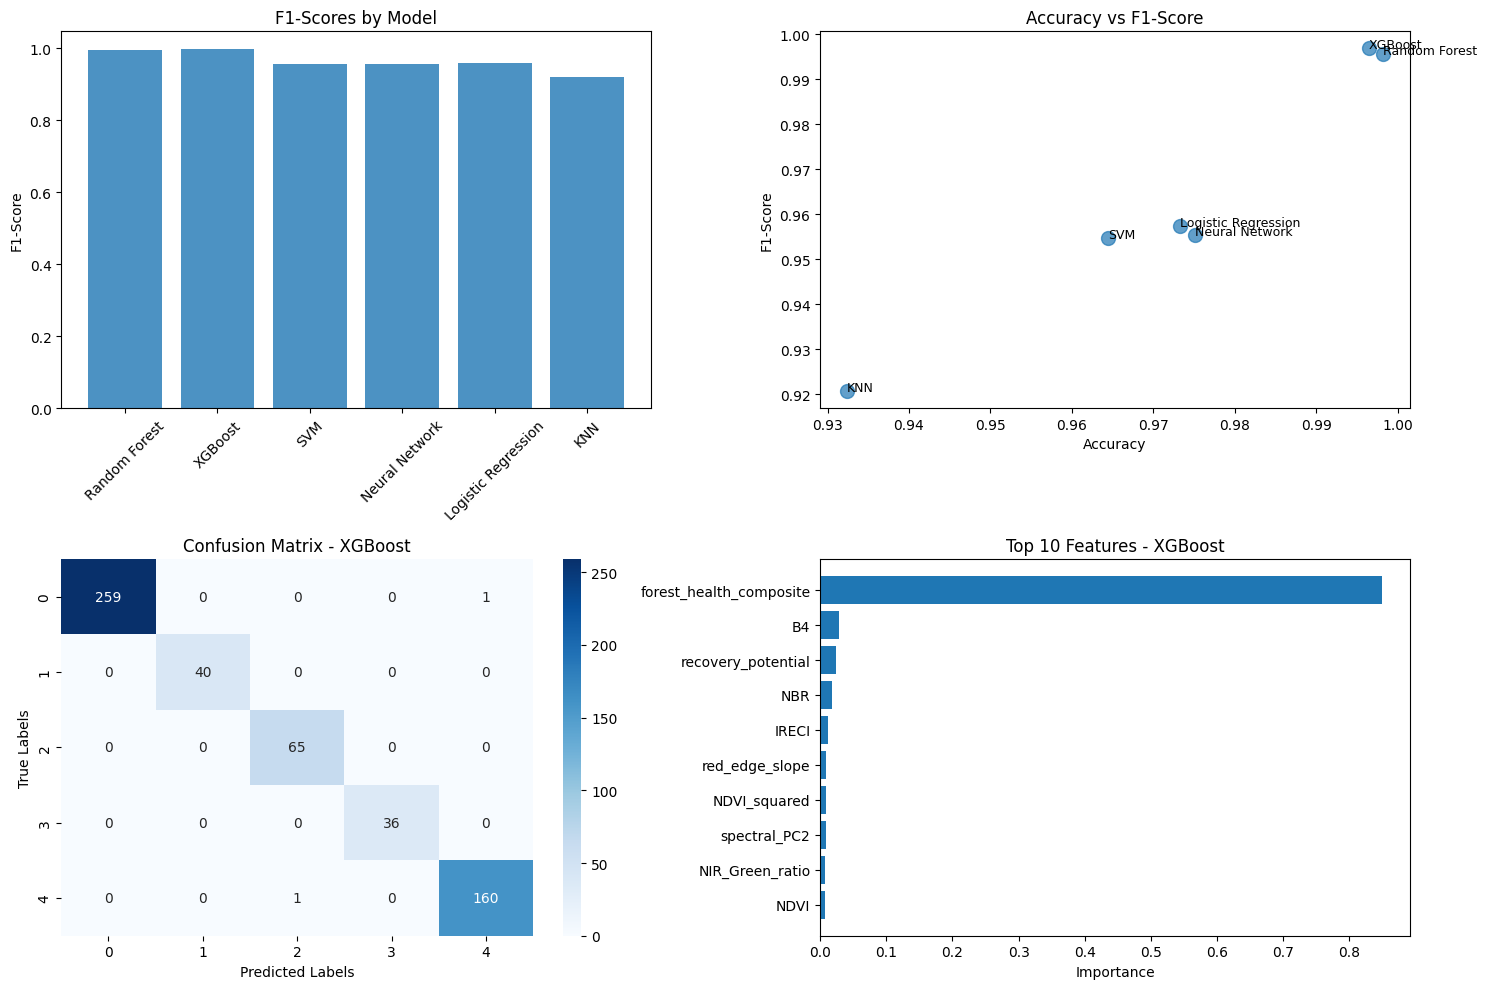

Model Comparison Results:
                 Model CV_Score Test_Accuracy Test_F1 Test_Precision  \
1              XGBoost   0.9946        0.9964  0.9968         0.9957   
0        Random Forest   0.9963        0.9982  0.9957         0.9970   
4  Logistic Regression   0.9536        0.9733  0.9574         0.9604   
3       Neural Network   0.9525        0.9751  0.9555         0.9560   
2                  SVM   0.9530        0.9644  0.9548         0.9540   
5                  KNN   0.9249        0.9324  0.9208         0.9296   

  Test_Recall  
1      0.9980  
0      0.9944  
4      0.9552  
3      0.9559  
2      0.9560  
5      0.9141  

Best Model: XGBoost

Sample Prediction: {'predicted_class': 'Poor', 'confidence': np.float32(0.99974114), 'probabilities': {'Critical': np.float32(8.425169e-05), 'Excellent': np.float32(7.246338e-05), 'Fair': np.float32(6.280083e-05), 'Good': np.float32(3.932836e-05), 'Poor': np.float32(0.99974114)}}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

class ForestHealthAnalysis:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_selector = None
        self.selected_feature_names = None
        self.all_feature_names = None
        
    def load_and_prepare_data(self):
        self.df = pd.read_csv(self.csv_file)
        
        # Remove system and geo columns
        cols_to_drop = [col for col in self.df.columns if any(x in col.lower() for x in ['system', '.geo', 'index'])]
        if cols_to_drop:
            self.df = self.df.drop(columns=cols_to_drop)
        
        # Handle missing values
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        
        for col in numeric_cols:
            self.df[col] = self.df[col].fillna(self.df[col].median())
        
        for col in categorical_cols:
            self.df[col] = self.df[col].fillna(self.df[col].mode()[0] if not self.df[col].mode().empty else 'Unknown')
        
        # Encode categorical variables
        for col in categorical_cols:
            if col != 'health_class_detailed' and self.df[col].nunique() <= 10:
                dummies = pd.get_dummies(self.df[col], prefix=col)
                self.df = pd.concat([self.df, dummies], axis=1)
                self.df.drop(col, axis=1, inplace=True)
        
        # Prepare target variable
        target_col = 'health_class_detailed'
        if target_col in self.df.columns:
            self.y = self.label_encoder.fit_transform(self.df[target_col])
            self.df.drop(target_col, axis=1, inplace=True)
        else:
            raise ValueError("Target column not found")
        
        # Get all numeric features
        numeric_features = self.df.select_dtypes(include=[np.number])
        self.all_feature_names = numeric_features.columns.tolist()
        
        # Select features
        k_features = min(25, numeric_features.shape[1])
        self.feature_selector = SelectKBest(score_func=f_classif, k=k_features)
        self.X = self.feature_selector.fit_transform(numeric_features, self.y)
        self.selected_feature_names = [self.all_feature_names[i] for i in self.feature_selector.get_support(indices=True)]
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        # Scale features
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
    def initialize_models(self):
        self.models = {
            'Random Forest': {
                'model': RandomForestClassifier(random_state=42, n_jobs=1),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [None, 20],
                    'min_samples_split': [5, 10]
                }
            },
            'XGBoost': {
                'model': xgb.XGBClassifier(random_state=42, n_jobs=1, eval_metric='mlogloss'),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [6, 9],
                    'learning_rate': [0.1, 0.2]
                }
            },
            'SVM': {
                'model': SVC(probability=True, random_state=42),
                'params': {
                    'C': [1, 10],
                    'kernel': ['rbf', 'poly']
                }
            },
            'Neural Network': {
                'model': MLPClassifier(random_state=42, max_iter=500),
                'params': {
                    'hidden_layer_sizes': [(100,), (100, 50)],
                    'alpha': [0.001, 0.01]
                }
            },
            'Logistic Regression': {
                'model': LogisticRegression(random_state=42, max_iter=1000),
                'params': {
                    'C': [1, 10],
                    'solver': ['liblinear', 'lbfgs']
                }
            },
            'KNN': {
                'model': KNeighborsClassifier(),
                'params': {
                    'n_neighbors': [5, 7],
                    'weights': ['uniform', 'distance']
                }
            }
        }
    
    def evaluate_model(self, name, model):
        cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='f1_macro', n_jobs=1)
        
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        
        self.results[name] = {
            'model': model,
            'cv_mean': cv_scores.mean(),
            'test_accuracy': accuracy_score(self.y_test, y_pred),
            'test_f1': f1_score(self.y_test, y_pred, average='macro'),
            'test_precision': precision_score(self.y_test, y_pred, average='macro', zero_division=0),
            'test_recall': recall_score(self.y_test, y_pred, average='macro', zero_division=0)
        }
        
        return self.results[name]['test_f1']
    
    def tune_hyperparameters(self, model_name, param_grid):
        model = self.models[model_name]['model']
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='f1_macro',
            cv=3,
            n_jobs=1
        )
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_estimator_
    
    def compare_models(self, tune_params=True):
        best_score = 0
        
        for name, model_info in self.models.items():
            try:
                model = model_info['model']
                
                if tune_params and model_info['params']:
                    model = self.tune_hyperparameters(name, model_info['params'])
                
                score = self.evaluate_model(name, model)
                
                if score > best_score:
                    best_score = score
                    self.best_model = name
                    
            except Exception as e:
                continue
    
    def generate_report(self):
        results_data = []
        for name, results in self.results.items():
            results_data.append({
                'Model': name,
                'CV_Score': f"{results['cv_mean']:.4f}",
                'Test_Accuracy': f"{results['test_accuracy']:.4f}",
                'Test_F1': f"{results['test_f1']:.4f}",
                'Test_Precision': f"{results['test_precision']:.4f}",
                'Test_Recall': f"{results['test_recall']:.4f}"
            })
        
        results_df = pd.DataFrame(results_data).sort_values('Test_F1', ascending=False)
        return results_df
    
    def plot_results(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        models = list(self.results.keys())
        f1_scores = [self.results[model]['test_f1'] for model in models]
        accuracies = [self.results[model]['test_accuracy'] for model in models]
        
        # F1 Scores
        axes[0, 0].bar(models, f1_scores, alpha=0.8)
        axes[0, 0].set_title('F1-Scores by Model')
        axes[0, 0].set_ylabel('F1-Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Accuracy vs F1
        axes[0, 1].scatter(accuracies, f1_scores, s=100, alpha=0.7)
        for i, model in enumerate(models):
            axes[0, 1].annotate(model, (accuracies[i], f1_scores[i]), fontsize=9)
        axes[0, 1].set_xlabel('Accuracy')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_title('Accuracy vs F1-Score')
        
        # Confusion Matrix for best model
        if self.best_model:
            best_model_obj = self.results[self.best_model]['model']
            y_pred = best_model_obj.predict(self.X_test)
            cm = confusion_matrix(self.y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
            axes[1, 0].set_title(f'Confusion Matrix - {self.best_model}')
            axes[1, 0].set_ylabel('True Labels')
            axes[1, 0].set_xlabel('Predicted Labels')
        
        # Feature Importance (if available)
        if self.best_model and hasattr(self.results[self.best_model]['model'], 'feature_importances_'):
            importances = self.results[self.best_model]['model'].feature_importances_
            top_indices = np.argsort(importances)[-10:]
            top_features = [self.selected_feature_names[i] for i in top_indices]
            top_importances = importances[top_indices]
            
            axes[1, 1].barh(range(len(top_features)), top_importances)
            axes[1, 1].set_yticks(range(len(top_features)))
            axes[1, 1].set_yticklabels(top_features)
            axes[1, 1].set_title(f'Top 10 Features - {self.best_model}')
            axes[1, 1].set_xlabel('Importance')
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self):
        if self.best_model:
            best_model_obj = self.results[self.best_model]['model']
            
            # Save model components
            model_data = {
                'model': best_model_obj,
                'scaler': self.scaler,
                'label_encoder': self.label_encoder,
                'feature_selector': self.feature_selector,
                'selected_features': self.selected_feature_names,
                'all_features': self.all_feature_names,
                'best_model_name': self.best_model
            }
            
            joblib.dump(model_data, 'forest_model_complete.pkl')
    
    def predict(self, new_data):
        if self.best_model:
            # Handle DataFrame input
            if isinstance(new_data, pd.DataFrame):
                # Ensure we have all the original features
                missing_features = [f for f in self.all_feature_names if f not in new_data.columns]
                for feature in missing_features:
                    new_data[feature] = 0
                
                # Reorder columns to match training data
                new_data = new_data[self.all_feature_names]
                new_data_array = new_data.values
            else:
                new_data_array = new_data
            
            # Apply feature selection
            new_data_selected = self.feature_selector.transform(new_data_array.reshape(1, -1))
            
            # Scale the data
            new_data_scaled = self.scaler.transform(new_data_selected)
            
            # Make prediction
            model = self.results[self.best_model]['model']
            prediction = model.predict(new_data_scaled)[0]
            probabilities = model.predict_proba(new_data_scaled)[0]
            
            predicted_class = self.label_encoder.inverse_transform([prediction])[0]
            
            return {
                'predicted_class': predicted_class,
                'confidence': max(probabilities),
                'probabilities': dict(zip(self.label_encoder.classes_, probabilities))
            }
    
    def run_full_analysis(self):
        self.load_and_prepare_data()
        self.initialize_models()
        self.compare_models(tune_params=True)
        results_df = self.generate_report()
        self.plot_results()
        self.save_model()
        return results_df, self.best_model

# Usage
def main():
    analyzer = ForestHealthAnalysis('forest_features_engineered.csv')
    results_df, best_model = analyzer.run_full_analysis()
    
    print("Model Comparison Results:")
    print(results_df)
    print(f"\nBest Model: {best_model}")
    
    # Example prediction using original data structure
    if len(analyzer.df) > 0:
        # Create a sample from the processed dataframe with all features
        sample_df = pd.DataFrame([analyzer.df.iloc[0]])
        prediction = analyzer.predict(sample_df)
        print(f"\nSample Prediction: {prediction}")

# Function to load and use saved model
def load_and_predict(data_file, model_file='forest_model_complete.pkl'):
    model_data = joblib.load(model_file)
    
    # Load new data
    new_data = pd.read_csv(data_file)
    
    # Apply feature selection and scaling
    all_features = model_data['all_features']
    missing_features = [f for f in all_features if f not in new_data.columns]
    for feature in missing_features:
        new_data[feature] = 0
    
    new_data_ordered = new_data[all_features]
    new_data_selected = model_data['feature_selector'].transform(new_data_ordered)
    new_data_scaled = model_data['scaler'].transform(new_data_selected)
    
    # Make predictions
    predictions = model_data['model'].predict(new_data_scaled)
    probabilities = model_data['model'].predict_proba(new_data_scaled)
    
    predicted_classes = model_data['label_encoder'].inverse_transform(predictions)
    
    results = pd.DataFrame({
        'predicted_class': predicted_classes,
        'confidence': np.max(probabilities, axis=1)
    })
    
    return results

if __name__ == "__main__":
    main()

Début du traitement des données...
Combinaison des 5 fichiers CSV...
Données combinées: (2397, 8)
Nombre de séries temporelles: 2397
Période couverte: 2020 - 2024
Préparation des séquences pour LSTM...
Forme des données LSTM: X_train(3835, 3, 1), y_train(3835,)
Entraînement du modèle LSTM...
LSTM entraîné
Entraînement des modèles ARIMA...
ARIMA entraîné
Entraînement des modèles Prophet...


19:14:20 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:14:24 - cmdstanpy - INFO - Chain [1]

Prophet entraîné
Prédictions LSTM...
Évaluation des modèles...
ARIMA - RMSE: 0.0192, MAE: 0.0149
Prophet - RMSE: 2.0322, MAE: 0.7658
LSTM - RMSE: 0.0996, MAE: 0.0511

Meilleur modèle: ARIMA avec RMSE: 0.0192

Génération des prédictions 2025 avec ARIMA...
Prédictions 2025 générées: 200 points
NDVI 2025 moyen: 0.1655
NDVI 2025 min: 0.0182
NDVI 2025 max: 0.4337


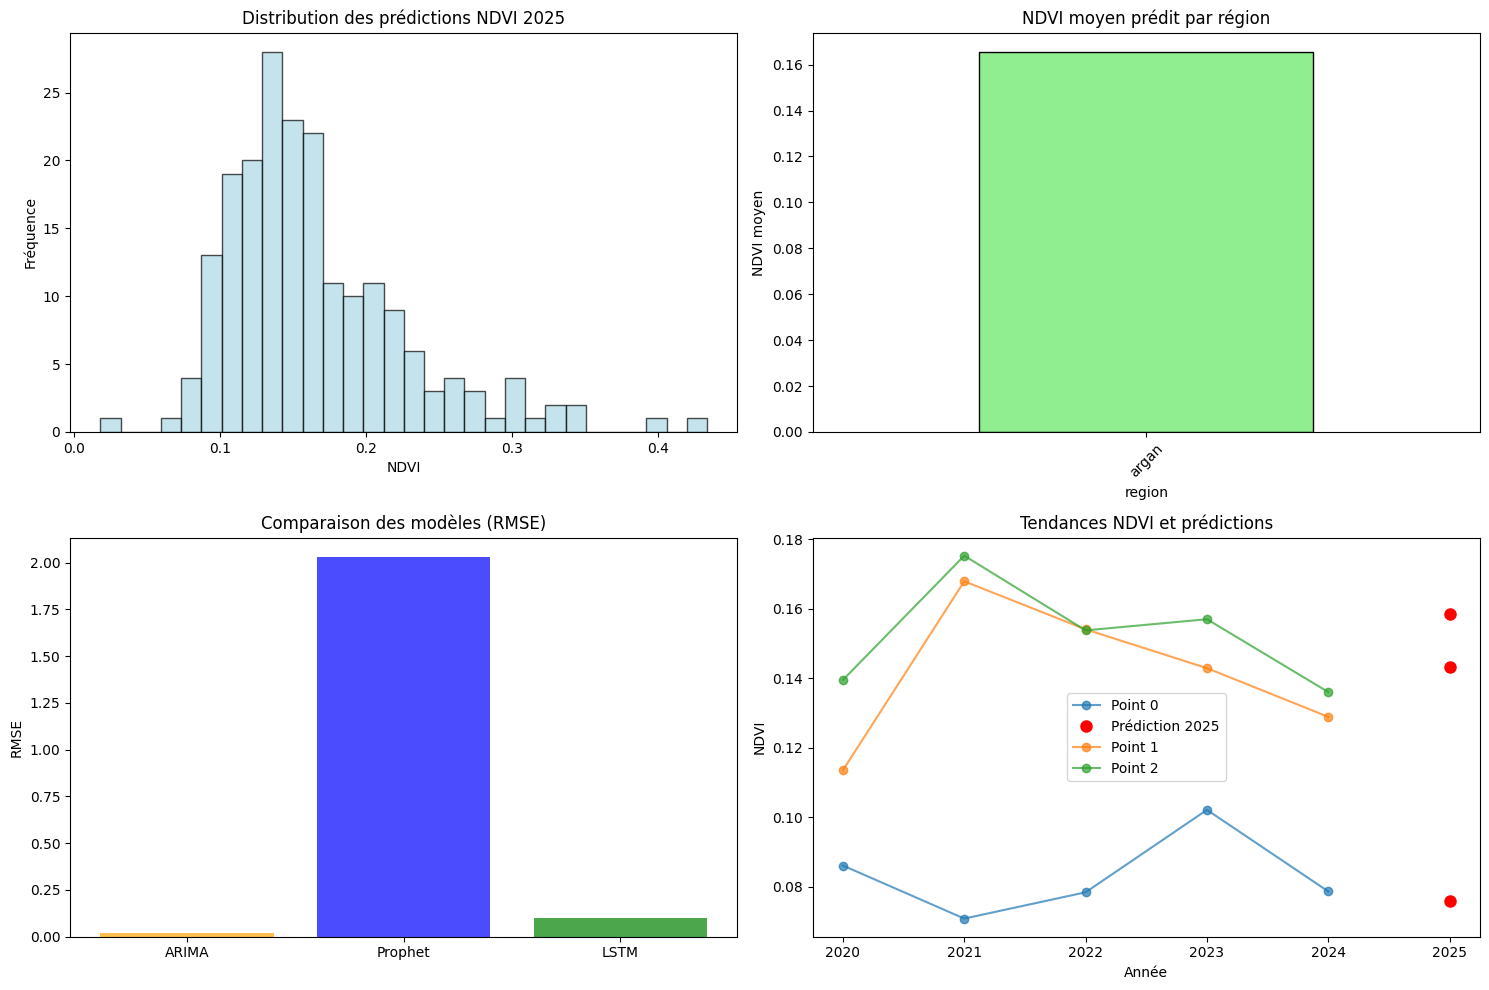


Fichiers sauvegardés:
- ndvi_predictions_2025_best_model.csv
- ndvi_predictions_comparison.png

Traitement terminé avec succès!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("Début du traitement des données...")

files = [
    'timeseries_samples_argan_2024.csv',
    'timeseries_samples_haut_atlas_2024.csv', 
    'timeseries_samples_mamora_2024.csv',
    'timeseries_samples_moyen_atlas_2024.csv',
    'timeseries_samples_rif_2024.csv'
]

print("Combinaison des 5 fichiers CSV...")
all_data = []
for file in files:
    df = pd.read_csv(file)
    df['region'] = file.split('_')[2]
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Données combinées: {combined_df.shape}")

years = [2020, 2021, 2022, 2023, 2024]
time_series_data = []
for idx, row in combined_df.iterrows():
    for i, year in enumerate(years):
        time_series_data.append({
            'id': idx,
            'region': row['region'],
            'year': year,
            'ndvi': row[f'NDVI_{year}'],
            'coordinates': row['.geo']
        })

ts_df = pd.DataFrame(time_series_data)
ts_df['date'] = pd.to_datetime(ts_df['year'].astype(str) + '-06-15')
ts_df = ts_df.sort_values(['id', 'date'])

print(f"Nombre de séries temporelles: {ts_df['id'].nunique()}")
print(f"Période couverte: {ts_df['year'].min()} - {ts_df['year'].max()}")

def prepare_sequences(data, n_steps=3):
    X, y = [], []
    for id_val in data['id'].unique():
        subset = data[data['id'] == id_val].sort_values('date')
        values = subset['ndvi'].values
        if len(values) >= n_steps + 1:
            for i in range(n_steps, len(values)):
                X.append(values[i-n_steps:i])
                y.append(values[i])
    return np.array(X), np.array(y)

print("Préparation des séquences pour LSTM...")
X, y = prepare_sequences(ts_df, n_steps=3)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_reshaped = X.reshape(-1, X.shape[1])
y_reshaped = y.reshape(-1, 1)

X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y_reshaped).reshape(y.shape)

train_size = int(0.8 * len(X))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Forme des données LSTM: X_train{X_train.shape}, y_train{y_train.shape}")

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

print("Entraînement du modèle LSTM...")
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
print("LSTM entraîné")

print("Entraînement des modèles ARIMA...")
arima_predictions = []
arima_actual = []
for id_val in ts_df['id'].unique()[:100]:
    subset = ts_df[ts_df['id'] == id_val].sort_values('date')
    if len(subset) >= 4:
        try:
            model = ARIMA(subset['ndvi'], order=(1,1,1))
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=1)
            arima_predictions.append(forecast.iloc[0])
            arima_actual.append(subset['ndvi'].iloc[-1])
        except:
            continue
print("ARIMA entraîné")

print("Entraînement des modèles Prophet...")
prophet_predictions = []
prophet_actual = []
for id_val in ts_df['id'].unique()[:100]:
    subset = ts_df[ts_df['id'] == id_val].sort_values('date')
    if len(subset) >= 3:
        try:
            prophet_df = subset[['date', 'ndvi']].copy()
            prophet_df.columns = ['ds', 'y']
            model = Prophet(yearly_seasonality=True)
            model.fit(prophet_df)
            future = model.make_future_dataframe(periods=1, freq='Y')
            forecast = model.predict(future)
            prophet_predictions.append(forecast['yhat'].iloc[-1])
            prophet_actual.append(subset['ndvi'].iloc[-1])
        except:
            continue
print("Prophet entraîné")

print("Prédictions LSTM...")
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)
lstm_predictions = scaler_y.inverse_transform(lstm_pred_scaled).flatten()
lstm_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("Évaluation des modèles...")
models_evaluation = {}

if len(arima_predictions) > 0:
    arima_rmse = np.sqrt(mean_squared_error(arima_actual, arima_predictions))
    arima_mae = mean_absolute_error(arima_actual, arima_predictions)
    models_evaluation['ARIMA'] = {'rmse': arima_rmse, 'mae': arima_mae}
    print(f"ARIMA - RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}")

if len(prophet_predictions) > 0:
    prophet_rmse = np.sqrt(mean_squared_error(prophet_actual, prophet_predictions))
    prophet_mae = mean_absolute_error(prophet_actual, prophet_predictions)
    models_evaluation['Prophet'] = {'rmse': prophet_rmse, 'mae': prophet_mae}
    print(f"Prophet - RMSE: {prophet_rmse:.4f}, MAE: {prophet_mae:.4f}")

lstm_rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_predictions))
lstm_mae = mean_absolute_error(lstm_actual, lstm_predictions)
models_evaluation['LSTM'] = {'rmse': lstm_rmse, 'mae': lstm_mae}
print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

best_model = min(models_evaluation.items(), key=lambda x: x[1]['rmse'])
print(f"\nMeilleur modèle: {best_model[0]} avec RMSE: {best_model[1]['rmse']:.4f}")

print(f"\nGénération des prédictions 2025 avec {best_model[0]}...")
predictions_2025 = []

if best_model[0] == 'LSTM':
    for id_val in ts_df['id'].unique():
        subset = ts_df[ts_df['id'] == id_val].sort_values('date')
        if len(subset) >= 3:
            last_values = subset['ndvi'].values[-3:]
            last_values_scaled = scaler_X.transform(last_values.reshape(-1, 3))
            last_values_scaled = last_values_scaled.reshape(1, 3, 1)
            pred_scaled = lstm_model.predict(last_values_scaled, verbose=0)
            pred = scaler_y.inverse_transform(pred_scaled)[0][0]
            predictions_2025.append({
                'id': id_val,
                'region': subset['region'].iloc[0],
                'NDVI_2024': subset['ndvi'].iloc[-1],
                'NDVI_2025_pred': pred,
                'model': 'LSTM'
            })

elif best_model[0] == 'ARIMA':
    for id_val in ts_df['id'].unique()[:200]:
        subset = ts_df[ts_df['id'] == id_val].sort_values('date')
        if len(subset) >= 4:
            try:
                model = ARIMA(subset['ndvi'], order=(1,1,1))
                fitted_model = model.fit()
                forecast = fitted_model.forecast(steps=1)
                predictions_2025.append({
                    'id': id_val,
                    'region': subset['region'].iloc[0],
                    'NDVI_2024': subset['ndvi'].iloc[-1],
                    'NDVI_2025_pred': forecast.iloc[0],
                    'model': 'ARIMA'
                })
            except:
                continue

elif best_model[0] == 'Prophet':
    for id_val in ts_df['id'].unique()[:200]:
        subset = ts_df[ts_df['id'] == id_val].sort_values('date')
        if len(subset) >= 3:
            try:
                prophet_df = subset[['date', 'ndvi']].copy()
                prophet_df.columns = ['ds', 'y']
                model = Prophet(yearly_seasonality=True)
                model.fit(prophet_df)
                future = model.make_future_dataframe(periods=1, freq='Y')
                forecast = model.predict(future)
                predictions_2025.append({
                    'id': id_val,
                    'region': subset['region'].iloc[0],
                    'NDVI_2024': subset['ndvi'].iloc[-1],
                    'NDVI_2025_pred': forecast['yhat'].iloc[-1],
                    'model': 'Prophet'
                })
            except:
                continue

predictions_df = pd.DataFrame(predictions_2025)
predictions_df.to_csv('ndvi_predictions_2025_best_model.csv', index=False)

print(f"Prédictions 2025 générées: {len(predictions_df)} points")
print(f"NDVI 2025 moyen: {predictions_df['NDVI_2025_pred'].mean():.4f}")
print(f"NDVI 2025 min: {predictions_df['NDVI_2025_pred'].min():.4f}")
print(f"NDVI 2025 max: {predictions_df['NDVI_2025_pred'].max():.4f}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(predictions_df['NDVI_2025_pred'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Distribution des prédictions NDVI 2025')
plt.xlabel('NDVI')
plt.ylabel('Fréquence')

plt.subplot(2, 2, 2)
region_means = predictions_df.groupby('region')['NDVI_2025_pred'].mean()
region_means.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('NDVI moyen prédit par région')
plt.xticks(rotation=45)
plt.ylabel('NDVI moyen')

plt.subplot(2, 2, 3)
model_names = list(models_evaluation.keys())
rmse_values = [models_evaluation[model]['rmse'] for model in model_names]
plt.bar(model_names, rmse_values, color=['orange', 'blue', 'green'], alpha=0.7)
plt.title('Comparaison des modèles (RMSE)')
plt.ylabel('RMSE')

plt.subplot(2, 2, 4)
sample_ids = predictions_df['id'].unique()[:3]
for i, id_val in enumerate(sample_ids):
    subset = ts_df[ts_df['id'] == id_val].sort_values('date')
    pred_2025 = predictions_df[predictions_df['id'] == id_val]['NDVI_2025_pred'].values[0]
    plt.plot(subset['date'].dt.year, subset['ndvi'], 'o-', label=f'Point {id_val}', alpha=0.7)
    plt.plot(2025, pred_2025, 'ro', markersize=8, label=f'Prédiction 2025' if i == 0 else "")
plt.title('Tendances NDVI et prédictions')
plt.xlabel('Année')
plt.ylabel('NDVI')
plt.legend()

plt.tight_layout()
plt.savefig('ndvi_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFichiers sauvegardés:")
print("- ndvi_predictions_2025_best_model.csv")
print("- ndvi_predictions_comparison.png")
print("\nTraitement terminé avec succès!")

In [5]:
import joblib

# Sauvegarde du meilleur modèle
if best_model[0] == 'LSTM':
    lstm_model.save('best_ndvi_model_lstm.h5')
    print("Modèle LSTM sauvegardé: best_ndvi_model_lstm.h5")
    
elif best_model[0] == 'ARIMA':
    # Pour ARIMA, on ne peut pas sauvegarder facilement tous les modèles individuels
    # On sauvegarde plutôt le modèle de prédiction pour un exemple
    joblib.dump({'model_type': 'ARIMA', 'order': (1,1,1)}, 'best_ndvi_model_arima.pkl')
    print("Configuration ARIMA sauvegardée: best_ndvi_model_arima.pkl")
    
elif best_model[0] == 'Prophet':
    # Pour Prophet, on sauvegarde un modèle d'exemple
    joblib.dump({'model_type': 'Prophet'}, 'best_ndvi_model_prophet.pkl')
    print("Configuration Prophet sauvegardée: best_ndvi_model_prophet.pkl")

# Sauvegarde des scalers pour LSTM
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Scalers sauvegardés: scaler_X.pkl, scaler_y.pkl")

# Sauvegarde des métriques du meilleur modèle
best_model_info = {
    'model_name': best_model[0],
    'rmse': best_model[1]['rmse'],
    'mae': best_model[1]['mae']
}
joblib.dump(best_model_info, 'best_model_info.pkl')
print("Informations du meilleur modèle sauvegardées: best_model_info.pkl")

Configuration ARIMA sauvegardée: best_ndvi_model_arima.pkl
Scalers sauvegardés: scaler_X.pkl, scaler_y.pkl
Informations du meilleur modèle sauvegardées: best_model_info.pkl
